# Causal Inference in Statistics: A Primer
Bill Behrman 2023-05-31

-   1 Preliminaries: Statistical and Causal Models
    -   1.4 Graphs
        -   Study question 1.4.1
        -   Study question 1.5.1
-   2 Graphical Models and Their Applications
    -   2.3 Colliders
        -   Study question 2.3.1
    -   2.4 d-separation
        -   Study question 2.4.1
    -   2.5 Model Testing and Causal Search
        -   Study question 2.5.1
-   3 The Effects of Interventions
    -   3.3 The Backdoor Criterion
        -   Study question 3.3.1
    -   3.4 The Front-Door Criterion
        -   Study question 3.4.1
    -   3.5 Conditional Interventions and Covariate-Specific Effects
        -   Study question 3.5.1
    -   3.8 Causal Inference in Linear Systems
        -   Study question 3.8.1

The following are solutions using the [pgmpy](https://pgmpy.org/) Python package to study questions from the book

J Pearl, M Glymour, NP Jewell. Causal Inference in Statistics: A Primer. Wiley, 2016.

The [book’s website](http://bayes.cs.ucla.edu/PRIMER/) contains PDFs for each chapter.

In [9]:
import networkx as nx
from pgmpy.base import DAG
from pgmpy.independencies import IndependenceAssertion, Independencies
from pgmpy.inference import CausalInference
from pgmpy.models import BayesianNetwork

The code below uses pgmpy version 0.1.22.

## 1 Preliminaries: Statistical and Causal Models

### 1.4 Graphs

Figure 1.8. A directed graph used in study question 1.4.1.

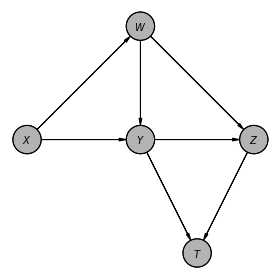

In [3]:
fig_1_8 = DAG(
    ebunch=[
        ("W", "Y"),
        ("W", "Z"),
        ("X", "W"),
        ("X", "Y"),
        ("Y", "T"),
        ("Y", "Z"),
        ("Z", "T"),
    ]
)

fig_1_8_node_pos = {"T": (3, 0), "W": (2, 4), "X": (0, 2), "Y": (2, 2), "Z": (4, 2)}

fig_1_8.to_daft(node_pos=fig_1_8_node_pos).render();

#### Study question 1.4.1

Consider the graph shown in Figure 1.8:

(a) Name all of the parents of Z.

In [4]:
fig_1_8.get_parents(node="Z")

['W', 'Y']

(b) Name all the ancestors of Z.

In [5]:
nx.ancestors(fig_1_8, source="Z")

{'W', 'X', 'Y'}

(c) Name all the children of W.

In [6]:
fig_1_8.get_children(node="W")

['Y', 'Z']

(d) Name all the descendants of W.

In [7]:
nx.descendants(fig_1_8, source="W")

{'T', 'Y', 'Z'}

(e) Draw all (simple) paths between X and T (i.e., no node should appear more than once).

In [8]:
list(nx.all_simple_paths(fig_1_8.to_undirected(), source="X", target="T"))

[['X', 'W', 'Y', 'T'],
 ['X', 'W', 'Y', 'Z', 'T'],
 ['X', 'W', 'Z', 'Y', 'T'],
 ['X', 'W', 'Z', 'T'],
 ['X', 'Y', 'W', 'Z', 'T'],
 ['X', 'Y', 'T'],
 ['X', 'Y', 'Z', 'T']]

(f) Draw all the directed paths between X and T.

In [9]:
list(nx.all_simple_paths(fig_1_8, source="X", target="T"))

[['X', 'W', 'Y', 'T'],
 ['X', 'W', 'Y', 'Z', 'T'],
 ['X', 'W', 'Z', 'T'],
 ['X', 'Y', 'T'],
 ['X', 'Y', 'Z', 'T']]

#### Study question 1.5.1

(a) Draw the graph that complies with the model.

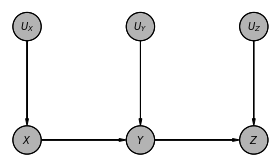

In [10]:
graph = DAG(ebunch=[("U_X", "X"), ("U_Y", "Y"), ("U_Z", "Z"), ("X", "Y"), ("Y", "Z")])

graph_node_pos = {
    "U_X": (0, 2),
    "U_Y": (2, 2),
    "U_Z": (4, 2),
    "X": (0, 0),
    "Y": (2, 0),
    "Z": (4, 0),
}

graph.to_daft(node_pos=graph_node_pos).render();

## 2 Graphical Models and Their Applications

### 2.3 Colliders

Figure 2.5. A directed graph for demonstrating conditional independence (error terms are not shown explicitly).

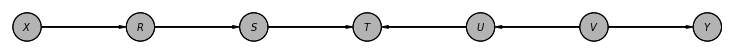

In [11]:
fig_2_5 = DAG(
    ebunch=[
        ("R", "S"),
        ("S", "T"),
        ("U", "T"),
        ("V", "U"),
        ("V", "Y"),
        ("X", "R"),
    ]
)

fig_2_5_node_pos = {
    "R": (2, 0),
    "S": (4, 0),
    "T": (6, 0),
    "U": (8, 0),
    "V": (10, 0),
    "X": (0, 0),
    "Y": (12, 0),
}

fig_2_5.to_daft(node_pos=fig_2_5_node_pos).render();

Figure 2.6. A directed graph in which P is a descendant of a collider.

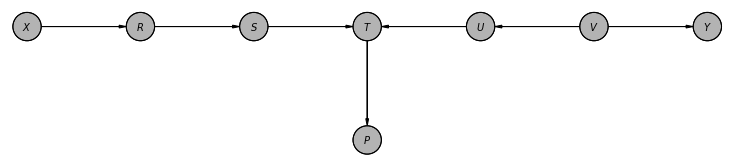

In [12]:
fig_2_6 = fig_2_5.copy()
fig_2_6.add_edges_from(ebunch=[("T", "P")])

fig_2_6_node_pos = fig_2_5_node_pos.copy()
fig_2_6_node_pos.update({"P": (6, -2)})

fig_2_6.to_daft(node_pos=fig_2_6_node_pos).render();

#### Study question 2.3.1

(a) List all pairs of variables in Figure 2.5 that are independent conditional on the set Z = {R, V}.

In [13]:
def pairs(v):
    return sorted([(x, y) for x in v for y in v if x < y])


def print_independent(graph, x, y, z=set()):
    if not graph.is_dconnected(start=x, end=y, observed=z):
        print(IndependenceAssertion(x, y, z))

In [14]:
z = {"R", "V"}

for x, y in pairs(set(fig_2_5.nodes()).difference(z)):
    print_independent(graph=fig_2_5, x=x, y=y, z=z)

(S ⟂ U | R, V)
(S ⟂ X | R, V)
(S ⟂ Y | R, V)
(T ⟂ X | R, V)
(T ⟂ Y | R, V)
(U ⟂ X | R, V)
(U ⟂ Y | R, V)
(X ⟂ Y | R, V)


(b) For each pair of nonadjacent variables in Figure 2.5, give a set of variables that, when conditioned on, renders that pair independent.

The function `print_implied_conditional_independencies()` below returns a minimal d-separator for each pair of nonadjacent, observed variables in a graph. This function differs from the R function `daggity::impliedConditionalIndependencies()` in that the later may return multiple independecies for each pair.

In [15]:
def print_implied_conditional_independencies(graph):
    independencies = Independencies()
    for x, y in pairs(set(graph.nodes()).difference(graph.latents)):
        if (not graph.has_edge(x, y)) and (not graph.has_edge(y, x)):
            z = graph.minimal_dseparator(start=x, end=y)
            if z is not None:
                independencies.add_assertions([x, y, z])
    return independencies

In [16]:
print_implied_conditional_independencies(fig_2_5)

(R ⟂ T | S)
(R ⟂ U)
(R ⟂ V)
(R ⟂ Y)
(S ⟂ U)
(S ⟂ V)
(S ⟂ X | R)
(S ⟂ Y)
(T ⟂ V | U)
(T ⟂ X | S)
(T ⟂ Y | V)
(U ⟂ X)
(U ⟂ Y | V)
(V ⟂ X)
(X ⟂ Y)

(c) List all pairs of variables in Figure 2.6 that are independent conditional on the set Z = {R, P}.

In [17]:
z = {"P", "R"}

for x, y in pairs(set(fig_2_6.nodes()).difference(z)):
    print_independent(graph=fig_2_6, x=x, y=y, z=z)

(S ⟂ X | P, R)
(T ⟂ X | P, R)
(U ⟂ X | P, R)
(V ⟂ X | P, R)
(X ⟂ Y | P, R)


(d) For each pair of nonadjacent variables in Figure 2.6, give a set of variables that, when conditioned on, renders that pair independent.

In [18]:
print_implied_conditional_independencies(fig_2_6)

(P ⟂ R | T)
(P ⟂ S | T)
(P ⟂ U | T)
(P ⟂ V | T)
(P ⟂ X | T)
(P ⟂ Y | V)
(R ⟂ T | S)
(R ⟂ U)
(R ⟂ V)
(R ⟂ Y)
(S ⟂ U)
(S ⟂ V)
(S ⟂ X | R)
(S ⟂ Y)
(T ⟂ V | U)
(T ⟂ X | S)
(T ⟂ Y | V)
(U ⟂ X)
(U ⟂ Y | V)
(V ⟂ X)
(X ⟂ Y)

(e) Suppose we generate data by the model described in Figure 2.5, and we fit them with the linear equation

Y = a + b \* X + c \* Z .

Which of the variables in the model may be chosen for Z so as to guarantee that the slope b would be equal to zero? \[Hint: Recall, a non-zero slope implies that X and Y are dependent given Z.\]

In [19]:
nodes = [set(), "R", "S", "T", "U", "V"]

for z in nodes:
    if not fig_2_5.is_dconnected(start="X", end="Y", observed=z):
        print(z)

set()
R
S
U
V


X and Y are marginally independent, so the Z term could be omitted. X and Y are conditionally independent when Z is any member of the set {R, S, U, V}.

(f) Suppose we generate data by the model described in Figure 2.6, and we fit them with the linear equation

Y = a + b \* X + c \* R + d \* S + e \* T + f \* P .

Which of the coefficients would be zero?

The coefficients for the following variables.

In [20]:
nodes = ["P", "R", "S", "T", "X"]

for x in nodes:
    if not fig_2_6.is_dconnected(start=x, end="Y", observed=set(nodes).difference(x)):
        print(x)

P
R
X


### 2.4 d-separation

Figure 2.9. A causal graph used in study question 2.4.1. All error terms (not shown) are assumed to be mutually independent.

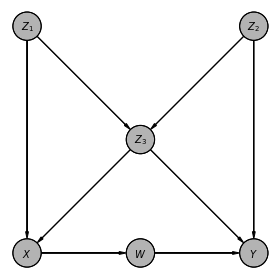

In [21]:
fig_2_9 = DAG(
    ebunch=[
        ("W", "Y"),
        ("X", "W"),
        ("Z_1", "X"),
        ("Z_1", "Z_3"),
        ("Z_2", "Y"),
        ("Z_2", "Z_3"),
        ("Z_3", "X"),
        ("Z_3", "Y"),
    ]
)

fig_2_9_node_pos = {
    "W": (2, 0),
    "X": (0, 0),
    "Y": (4, 0),
    "Z_1": (0, 4),
    "Z_2": (4, 4),
    "Z_3": (2, 2),
}

fig_2_9.to_daft(node_pos=fig_2_9_node_pos).render();

#### Study question 2.4.1

(a) For each pair of nonadjacent nodes in this graph, find a set of variables that d-separates that pair. What does this list tell us about independencies in the data?

In [22]:
print_implied_conditional_independencies(fig_2_9)

(W ⟂ Z_1 | X)
(W ⟂ Z_2 | X)
(W ⟂ Z_3 | X)
(X ⟂ Y | Z_3, W, Z_2)
(X ⟂ Z_2 | Z_3, Z_1)
(Y ⟂ Z_1 | Z_3, W, Z_2)
(Z_1 ⟂ Z_2)

For the data to be consistent with the causal model represented by the graph, they should reflect the above conditional independencies.

(b) Repeat question (a) assuming that only variables in the set {Z_3, W, X, Z_1} can be measured.

In [23]:
fig_2_9.latents = set(fig_2_9.nodes()).difference({"W", "X", "Z_1", "Z_3"})

print_implied_conditional_independencies(fig_2_9)

(W ⟂ Z_1 | X)
(W ⟂ Z_3 | X)

In [24]:
fig_2_9.latents = set()

(c) For each pair of nonadjacent nodes in the graph, determine whether they are independent conditional on all other variables.

In [25]:
for x, y in pairs(fig_2_9.nodes()):
    print_independent(
        graph=fig_2_9, x=x, y=y, z=set(fig_2_9.nodes()).difference({x, y})
    )

(W ⟂ Z_1 | Y, Z_3, X, Z_2)
(X ⟂ Y | Z_3, W, Z_1, Z_2)
(X ⟂ Z_2 | Y, Z_3, W, Z_1)
(Y ⟂ Z_1 | Z_3, W, X, Z_2)


(d) For every variable V in the graph, find a minimal set of nodes that renders V independent of all other variables in the graph.

In [26]:
def print_markov_blanket(graph, node):
    print(f"Markov blanket of {node}:", sorted(graph.get_markov_blanket(node)))

In [27]:
for node in sorted(fig_2_9.nodes()):
    print_markov_blanket(graph=fig_2_9, node=node)

Markov blanket of W: ['X', 'Y', 'Z_2', 'Z_3']
Markov blanket of X: ['W', 'Z_1', 'Z_3']
Markov blanket of Y: ['W', 'Z_2', 'Z_3']
Markov blanket of Z_1: ['X', 'Z_2', 'Z_3']
Markov blanket of Z_2: ['W', 'Y', 'Z_1', 'Z_3']
Markov blanket of Z_3: ['W', 'X', 'Y', 'Z_1', 'Z_2']


(e) Suppose we wish to estimate the value of Y from measurements taken on all other variables in the model. Find the smallest set of variables that would yield as good an estimate of Y as when we measured all variables.

In [28]:
print_markov_blanket(graph=fig_2_9, node="Y")

Markov blanket of Y: ['W', 'Z_2', 'Z_3']


(f) Repeat question (e) assuming that we wish to estimate the value of Z_2.

In [29]:
print_markov_blanket(graph=fig_2_9, node="Z_2")

Markov blanket of Z_2: ['W', 'Y', 'Z_1', 'Z_3']


(g) Suppose we wish to predict the value of Z_2 from measurements of Z_3. Would the quality of our prediction improve if we add measurement of W? Explain.

In [30]:
fig_2_9.is_dconnected(start="W", end="Z_2", observed="Z_3")

True

When conditioned on Z_3, the variables W and Z_2 are connected, hence they are not independent. Thus, it would likely be advantageous to add W.

### 2.5 Model Testing and Causal Search

#### Study question 2.5.1

(a) Which of the arrows in Figure 2.9 can be reversed without being detected by any statistical test? \[Hint: Use the criterion for equivalence class.\]

This question can be [answered](https://github.com/behrman/cis/blob/master/solutions_dagitty.md#study-question-251) with the R function `dagitty::equivalenceClass()`, which generates a complete partially directed graph (CPDAG) that represents all the graphs that are Markov equivalent to the input DAG. There is no comparable functionality in pgmpy as of version 0.1.22 (`DAG.to_pdag()` has not been implemented).

(d) Write down a regression equation for Y such that, if a certain coefficient in that equation is nonzero, the model of Figure 2.9 is wrong.

Here are conditional independencies for `fig_2_9`.

In [31]:
print_implied_conditional_independencies(fig_2_9)

(W ⟂ Z_1 | X)
(W ⟂ Z_2 | X)
(W ⟂ Z_3 | X)
(X ⟂ Y | Z_3, W, Z_2)
(X ⟂ Z_2 | Z_3, Z_1)
(Y ⟂ Z_1 | Z_3, W, Z_2)
(Z_1 ⟂ Z_2)

If we assume that the model is correct and linear, then the conditional independence of X and Y conditioned on {W, Z_1, Z_3} would imply that the coefficient b for this linear regression

Y = a + b \* X + c \* W + d \* Z_1 + e \* Z_3

should be zero.

(e) Repeat question (d) for variable Z_3.

Similarly, the conditional independence of Z_3 and W conditioned on X would imply that the coefficient b for this linear regression

Z_3 = a + b \* W + c \* X

should be zero.

(f) Repeat question (e) assuming the X is not measured.

Assuming that X is not measured, we will convert it to a latent variable.

In [32]:
fig_2_9.latents = "X"

print_implied_conditional_independencies(fig_2_9)

(W ⟂ Z_2 | Z_3, Z_1)
(Y ⟂ Z_1 | Z_3, W, Z_2)
(Z_1 ⟂ Z_2)

In this case, Z_3 is not conditionally independent with any other variable, so no such regression exists.

In [33]:
fig_2_9.latents = set()

(g) How many regression equations of the type described in (d) and (e) are needed to ensure that the model is fully tested, namely, that if it passes all these tests, it cannot be refuted by additional tests of this kind. \[Hint: Ensure that you test every vanishing partial regression coefficient that is implied by the product decomposition (1.29).\]

This question can be [answered](https://github.com/behrman/cis/blob/master/solutions_dagitty.md#study-question-251) by using the R function `dagitty::impliedConditionalIndependencies()` to generate a basis set of conditional independencies. There is no comparable functionality in pgmpy as of version 0.1.22.

## 3 The Effects of Interventions

### 3.3 The Backdoor Criterion

Figure 3.8. Causal graph used to illustrate the backdoor criterion in the following study questions.

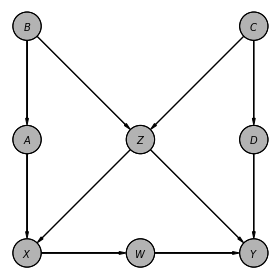

In [34]:
fig_3_8 = DAG(
    ebunch=[
        ("A", "X"),
        ("B", "A"),
        ("B", "Z"),
        ("C", "D"),
        ("C", "Z"),
        ("D", "Y"),
        ("W", "Y"),
        ("X", "W"),
        ("Z", "X"),
        ("Z", "Y"),
    ]
)

fig_3_8_node_pos = {
    "A": (0, 2),
    "B": (0, 4),
    "C": (4, 4),
    "D": (4, 2),
    "W": (2, 0),
    "X": (0, 0),
    "Y": (4, 0),
    "Z": (2, 2),
}

fig_3_8.to_daft(node_pos=fig_3_8_node_pos).render();

#### Study question 3.3.1

Consider the graph in Figure 3.8:

(a) List all of the sets of variables that satisfy the backdoor criterion to determine the causal effect of X on Y.

This question can be [answered](https://github.com/behrman/cis/blob/master/solutions_dagitty.md#study-question-331) by using the R function `dagitty::adjustmentSets()` to generate all sets of variables that satisfy the backdoor criterion. There is no comparable functionality in pgmpy as of version 0.1.22. (`get_all_backdoor_adjustment_sets()` below returns *minimal* sets).

(b) List all of the minimal sets of variables that satisfy the backdoor criterion to determine the causal effect of X on Y (i.e., any set of variables such that, if you removed any one of the variables from the set, it would no longer meet the criterion).

In [35]:
inference = CausalInference(BayesianNetwork(fig_3_8))

In [36]:
inference.get_all_backdoor_adjustment_sets("X", "Y")

frozenset({frozenset({'C', 'Z'}),
           frozenset({'A', 'Z'}),
           frozenset({'D', 'Z'}),
           frozenset({'B', 'Z'})})

Note: As of pgmpy version 0.1.22, the computation for `get_all_backdoor_adjustment_sets()` grows exponentially with the number of nodes in the graph, so it is only suitable for relatively small graphs.

(c) List all minimal sets of variables that need be measured in order to identify the effect of D on Y.

In [37]:
inference.get_all_backdoor_adjustment_sets("D", "Y")

frozenset({frozenset({'A', 'Z'}),
           frozenset({'B', 'Z'}),
           frozenset({'W', 'Z'}),
           frozenset({'X', 'Z'}),
           frozenset({'C'})})

Repeat, for the effect of {D, W} on Y.

This question can be [answered](https://github.com/behrman/cis/blob/master/solutions_dagitty.md#study-question-331) by using the R function `dagitty::adjustmentSets()`, which allows the exposure and outcome to be sets of variables. There is no comparable functionality in pgmpy as of version 0.1.22.

### 3.4 The Front-Door Criterion

#### Study question 3.4.1

Assume that in Figure 3.8, only X, Y, and one additional variable can be measured. Which variable would allow the identification of the effect of X on Y? What would that effect be?

In [38]:
inference.get_all_frontdoor_adjustment_sets("X", "Y")

frozenset({frozenset({'W'})})

We saw in question 3.3.1 (b) that all backdoor adjustment sets for the effect of X on Y in Figure 3.8 require at least two variables. The single variable W, however, is a front-door adjustment set through which the effect of X on Y could be identified.

Note: As of pgmpy version 0.1.22, the computation for `get_all_frontdoor_adjustment_sets()` grows exponentially with the number of nodes in the graph, so it is only suitable for relatively small graphs.

### 3.5 Conditional Interventions and Covariate-Specific Effects

#### Study question 3.5.1

Consider the causal model of Figure 3.8.

(a) Find an expression for the c-specific effect of X on Y.
(b) Identify a set of four variables that need to be measured in order to estimate the z-specific effect of X on Y.

These questions can be [answered](https://github.com/behrman/cis/blob/master/solutions_dagitty.md#study-question-351) by using the R functions `dagitty::adjustedNodes()` and `dagitty::adjustmentSets()`. There is no comparable functionality in pgmpy as of version 0.1.22.

### 3.8 Causal Inference in Linear Systems

Figure 3.18. Graph corresponding to Model 3.1 in study question 3.8.1.

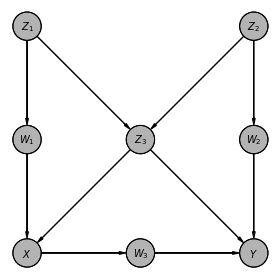

In [39]:
fig_3_18 = DAG(
    ebunch=[
        ("W_1", "X"),
        ("W_2", "Y"),
        ("W_3", "Y"),
        ("X", "W_3"),
        ("Z_1", "W_1"),
        ("Z_1", "Z_3"),
        ("Z_2", "W_2"),
        ("Z_2", "Z_3"),
        ("Z_3", "X"),
        ("Z_3", "Y"),
    ]
)

fig_3_18_node_pos = {
    "W_1": (0, 2),
    "W_2": (4, 2),
    "W_3": (2, 0),
    "X": (0, 0),
    "Y": (4, 0),
    "Z_1": (0, 4),
    "Z_2": (4, 4),
    "Z_3": (2, 2),
}

fig_3_18.to_daft(node_pos=fig_3_18_node_pos).render();

#### Study question 3.8.1

Given the model depicted above, answer the following questions:

(a) Identify three testable implications of this model.

In [40]:
print_implied_conditional_independencies(fig_3_18)

(W_1 ⟂ W_2)
(W_1 ⟂ W_3 | X)
(W_1 ⟂ Y | Z_3, Z_1, W_3)
(W_1 ⟂ Z_2)
(W_1 ⟂ Z_3 | Z_1)
(W_2 ⟂ W_3 | Z_2)
(W_2 ⟂ X | Z_2)
(W_2 ⟂ Z_1)
(W_2 ⟂ Z_3 | Z_2)
(W_3 ⟂ Z_1 | X)
(W_3 ⟂ Z_2 | X)
(W_3 ⟂ Z_3 | X)
(X ⟂ Y | W_2, Z_3, W_3)
(X ⟂ Z_1 | W_1, Z_3)
(X ⟂ Z_2 | W_1, Z_3)
(Y ⟂ Z_1 | W_2, Z_3, W_3)
(Y ⟂ Z_2 | W_2, Z_3, W_3)
(Z_1 ⟂ Z_2)

The above conditional independencies are all testable implications of this model.

(b) Identify a testable implication assuming that only X, Y, W_3, and Z_3 are observed.

In [41]:
fig_3_18.latents = set(fig_3_18.nodes()).difference({"W_3", "X", "Y", "Z_3"})

print_implied_conditional_independencies(fig_3_18)

(W_3 ⟂ Z_3 | X)

W_3 and Z_3 are independent conditional on X.

In [42]:
fig_3_18.latents = set()

(e) If we regress Z_1 on all other variables in the model, which regression coefficients will be zero?

In [43]:
print_markov_blanket(graph=fig_3_18, node="Z_1")

Markov blanket of Z_1: ['W_1', 'Z_2', 'Z_3']


In [44]:
set(fig_3_18.nodes()).difference({"Z_1"}.union(fig_3_18.get_markov_blanket("Z_1")))

{'W_2', 'W_3', 'X', 'Y'}

Z_1 is d-separated from the variables {W_2, W_3, X, Y} by the set {W_1, Z_2, Z_3}. This implies that in a regression of Z_1 on all other variables, the regression coefficients of {W_2, W_3, X, Y} would be zero.

(g) Assume that variables Z_2 and W_2 cannot be measured. Find a way to estimate b using regression coefficients. \[Hint: Find a way to turn Z_1 into an instrumental variable for b.\]

This question can be [answered](https://github.com/behrman/cis/blob/master/solutions_dagitty.md#study-question-381) by using the R function `dagitty::instrumentalVariables()`, which generates a list of instrumental variables under linearity assumptions. There is no comparable functionality in pgmpy as of version 0.1.22.